# Titanic Disaster Analysis(With 76.6% accuracy)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,learning_curve
from sklearn.preprocessing import Imputer,OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score,GridSearchCV
import xgboost as xgb

In [2]:
gender=pd.read_csv("D:/Learning Materials/Data Science projects/titanic/gender_submission.csv")
test=pd.read_csv("D:/Learning Materials/Data Science projects/titanic/test.csv")
train=pd.read_csv("D:/Learning Materials/Data Science projects/titanic/train.csv")

In [38]:
train.head()

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,1.0,3.0,1.0,22.0,1.0,0.0,7.2500
1,1.0,0.0,0.0,1.0,0.0,38.0,1.0,0.0,71.2833
2,0.0,0.0,1.0,3.0,0.0,26.0,0.0,0.0,7.9250
3,0.0,0.0,1.0,1.0,0.0,35.0,1.0,0.0,53.1000
4,0.0,0.0,1.0,3.0,1.0,35.0,0.0,0.0,8.0500


In [4]:
del train["Name"]
del train["PassengerId"]
del train["Cabin"]
del train["Ticket"]
del test["Name"]
del test["PassengerId"]
del test["Cabin"]
del test["Ticket"]

### Dealing With Missing Data 

In [5]:
train.Age=train["Age"].fillna(train["Age"].mean())
test.Age=test["Age"].fillna(test["Age"].mean())
test.Fare=test["Fare"].replace({0:10})
test.Fare=test["Fare"].fillna(10)
train.Fare=train.Fare.replace({0:10})
train["Embarked"]=train["Embarked"].fillna("Q")

# <font color='pink'> Visualizaton<font>

C:\Users\HOME\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


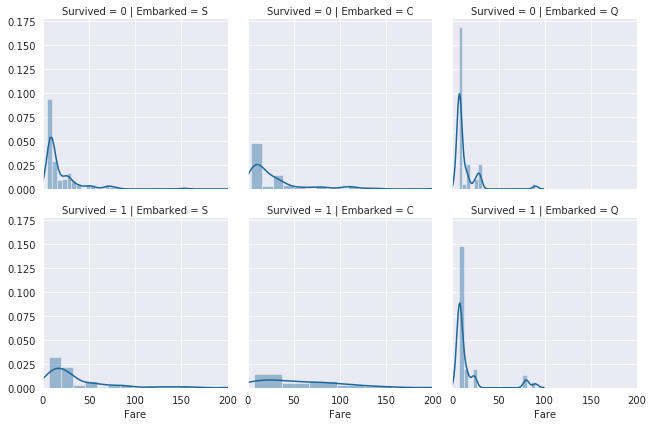

In [6]:
with sns.axes_style("darkgrid"):
    sns.FacetGrid(train,col="Embarked",row='Survived').map(sns.distplot,"Fare",color=(0.11,0.4,0.6),kde=True)
    plt.xlim(0,200)


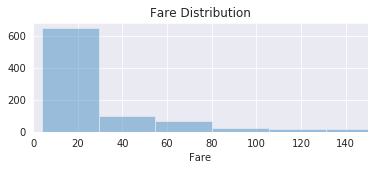

In [7]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(6,2))
    sns.distplot(train["Fare"],bins=20,kde=False)
    plt.xlim(0,150)
    plt.title("Fare Distribution")


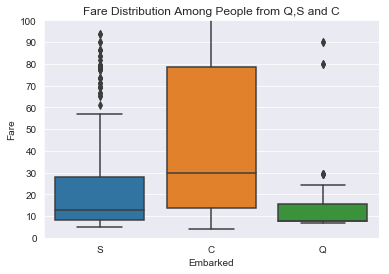

In [8]:
with sns.axes_style("darkgrid"):
    sns.boxplot(train["Embarked"],train["Fare"])
    plt.title("Fare Distribution Among People from Q,S and C")
    plt.yticks([i for i in range(0,110,10)])
    plt.ylim(0,100)
    plt.show()


# Insights About Embarked
<font color='blue'>


> Fare variability is high for people from C i.e standard deviation is 84

> 77.77% of all passengers who didn't survive are from S

>>72.27% of all the passengers are from S

>8.5% of all passengers who didn't survive are from Q

>> 8.6% of all the passengers are from Q
 
> 13.67% of all passengers who didn't survive are from C

>>18.88% of all the passengers are from C

# Creating New Category

In [9]:
labelencoder=LabelEncoder()
train["Sex"]=labelencoder.fit_transform(train["Sex"])
test["Sex"]=labelencoder.fit_transform(test["Sex"])
train["Embarked"]=labelencoder.fit_transform(train["Embarked"])
test["Embarked"]=labelencoder.fit_transform(test["Embarked"])

# One Hot Encoding

In [10]:
survived=train.pop("Survived")

In [11]:
ohe=OneHotEncoder(categorical_features=[-1])
train=ohe.fit_transform(train).toarray()
train=pd.DataFrame(train)

C:\Users\HOME\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\HOME\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:385: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [12]:
ohe=OneHotEncoder(categorical_features=[-1])
test=ohe.fit_transform(test).toarray()
test=pd.DataFrame(test)

C:\Users\HOME\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\HOME\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:385: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [13]:
test.head()

,0,1,2,3,4,5,6,7,8
0,0.0,1.0,0.0,3.0,1.0,34.5,0.0,0.0,7.8292
1,0.0,0.0,1.0,3.0,0.0,47.0,1.0,0.0,7.0000
2,0.0,1.0,0.0,2.0,1.0,62.0,0.0,0.0,9.6875
3,0.0,0.0,1.0,3.0,1.0,27.0,0.0,0.0,8.6625
4,0.0,0.0,1.0,3.0,0.0,22.0,1.0,1.0,12.2875


# Spliting DataSet

In [14]:
x=train
y=survived

In [15]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=0)

# Random Forest Algorithm

In [16]:
forest=RandomForestClassifier(n_estimators=500,criterion="gini",max_depth=5,max_features=4,random_state=0)
forest.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [17]:
confusion_matrix(y_test,forest.predict(x_test))

array([[103,   7],
       [ 23,  46]], dtype=int64)

In [70]:
pred=forest.predict(test)

# 10-Fold Cross Validation

In [71]:
accuracies=cross_val_score(estimator=forest,X=x_train,y=y_train,cv=10)
accuracies.mean()

0.8301184887100381

In [72]:
accuracies.std()

0.032589521557949475

In [ ]:
#help(forest)

### Grid Search for Random Forest

In [ ]:
parameters=[{'criterion':['gini'],'max_features':[4,3,2],'max_depth':[3,4,5]}]
grid=GridSearchCV(estimator=forest,
                 param_grid=parameters,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=-1)
grid=grid.fit(x_train,y_train)

In [ ]:
grid.best_score_

In [ ]:
grid.best_params_

# Xgboost

In [18]:
boost=xgb.XGBClassifier(max_depth=2,n_estimators=500,learning_rate=0.071)
boost.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.071, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [47]:
confusion_matrix(y_train,boost.predict(x_train))

array([[409,  30],
       [ 58, 215]], dtype=int64)

In [48]:
confusion_matrix(y_test,boost.predict(x_test))

array([[102,   8],
       [ 20,  49]], dtype=int64)

### <font color='blue'> Grid Search For Xgboost

In [85]:
parameters=[{'n_estimators':[500],'max_depth':[2],'learning_rate':[0.071,0.7,0.711],'gamma':[0.01,0,0.01]}]
grid=GridSearchCV(estimator=boost,
                 param_grid=parameters,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=-1)
grid=grid.fit(x_train,y_train)

In [86]:
grid.best_score_

0.8441011235955056

In [87]:
grid.best_params_

{'gamma': 0, 'learning_rate': 0.071, 'max_depth': 2, 'n_estimators': 500}

In [ ]:
"""del gender["Survived"]
submission=pd.concat([gender,pd.DataFrame(pred)],axis=1)
submission=submission.rename(columns={0:"Survived"})
submission.to_csv("Submission.csv")"""

# Learning Curve

In [54]:
def learning_curves(estimator,X,y,train_sizes,cv):
    sns.set_style("darkgrid")
    plt.figure()
    train_size=[1,100,200,350,500,600]
    train_size,train_scores,test_scores=learning_curve(estimator,X,y,train_sizes=train_sizes,
                                                    cv=cv,scoring="accuracy",shuffle=True)
    train_scores_mean=train_scores.mean(axis=1)
    test_scores_mean=test_scores.mean(axis=1)
    plt.plot(train_size,train_scores_mean,label="Training Error",color="red")
    plt.plot(train_size,test_scores_mean,label="Validation Error")
    plt.xlabel("Training size")
    plt.ylabel("Accuracy")
    plt.title("Learning Curve For"+str(estimator))
    plt.legend()
    plt.ylim(0.65,0.95)

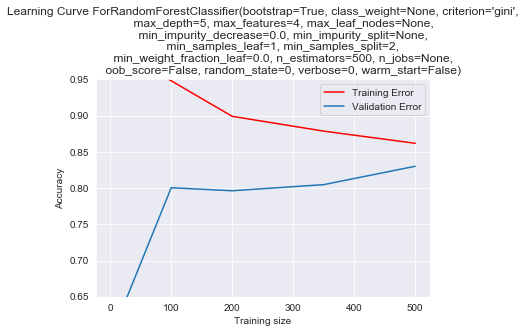

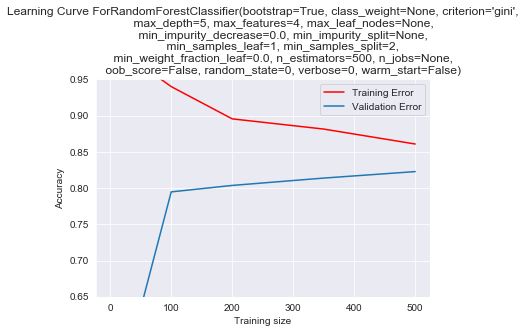

In [57]:
learning_curves(forest,x_train,y_train,train_size,10)
learning_curves(forest,x,y,train_size,10)

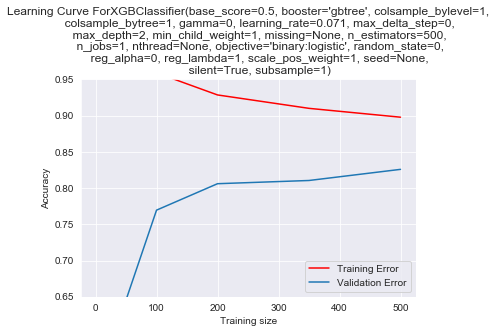

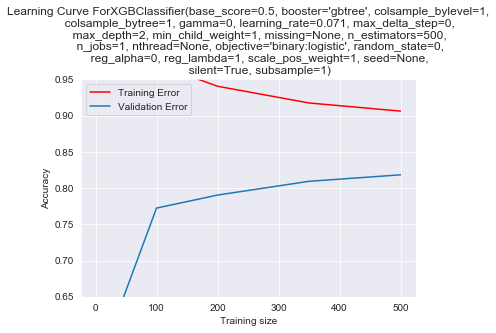

In [58]:
learning_curves(boost,x_train,y_train,train_size,10)
learning_curves(boost,x,y,train_size,10)